In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class FastSlam(Mcl): ###fastslam3fastslam
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds, \
                 distance_dev_rate=0.14, direction_dev=0.05): #envmapとlandmark_numを入れ替え
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)

In [3]:
class FastSlamAgent(MclAgent): ###fastslam3fsa
    def __init__(self, time_interval, nu, omega, particle_pose, landmark_num, particle_num=100, \
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, particle_pose, None, particle_num, motion_noise_stds)
    
        self.pf = FastSlam(particle_num, particle_pose, landmark_num, motion_noise_stds) #MclAgentの中で作られたMclのオブジェクトは破棄

    def decision(self, observation):
        return super().decision([])

<IPython.core.display.Javascript object>


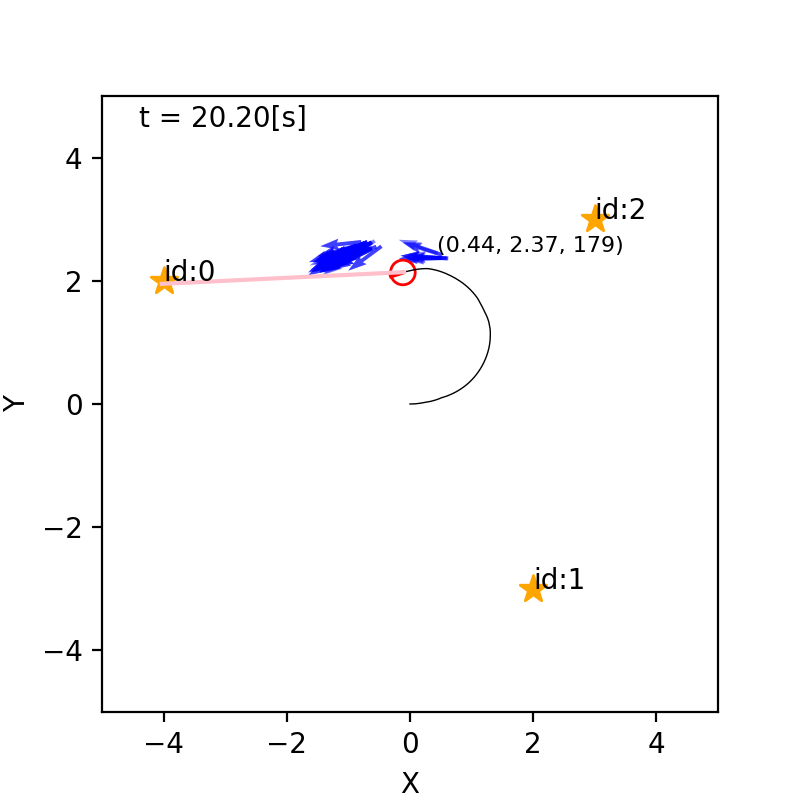

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, init_pose, len(m.landmarks)) #エージェントのクラスを入れ替え
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()